# 🔁 06 - Recursive Forecasting of Input Features (Multi-Horizon)
This notebook recursively forecasts future values of key input features over multiple horizons:
- 1 day, 1 week, 1 month, 3 months, 6 months, 12 months

Each feature is predicted using its own lagged values and calendar features, recursively moving forward.

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Load merged dataset
df = pd.read_csv('../data/processed/merged_energy_data_final_step_1.csv', parse_dates=['utc_timestamp'])
df.set_index('utc_timestamp', inplace=True)
df = df.sort_index()

# Forecast horizons (hours)
horizons = {
    "1d": 24,
    "7d": 168,
    "1m": 720,
    "3m": 2160,
    "6m": 4320,
    "12m": 8760
}

# Features to forecast
features_to_forecast = [
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_load_actual_entsoe_transparency',
    'Gas_Price',
    'Oil_Price',
    'DE_radiation_direct_horizontal',
    'DE_radiation_diffuse_horizontal', 
    'DE_temperature'
]

# Base history
base_history = df.copy().iloc[-900:].copy()
recursive_forecasts = {}


📡 Forecasting: DE_solar_generation_actual
 - Horizon: 1d (24 hours)


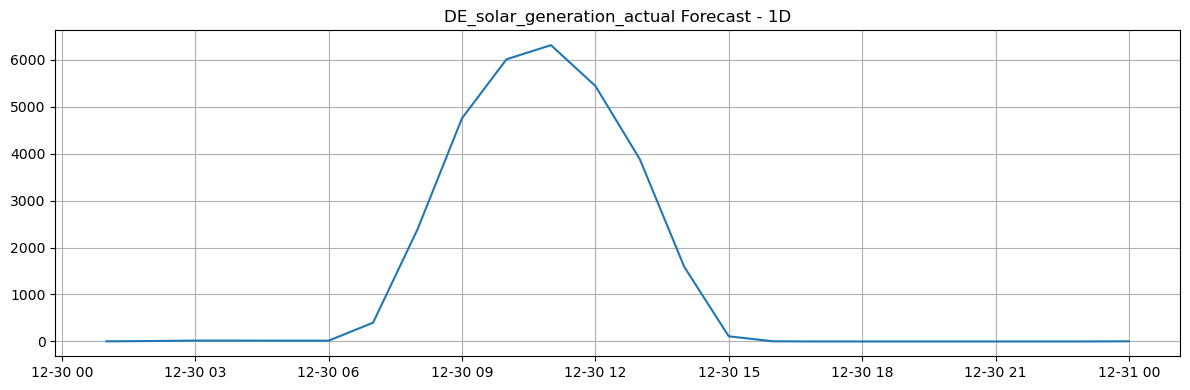

 - Horizon: 7d (168 hours)


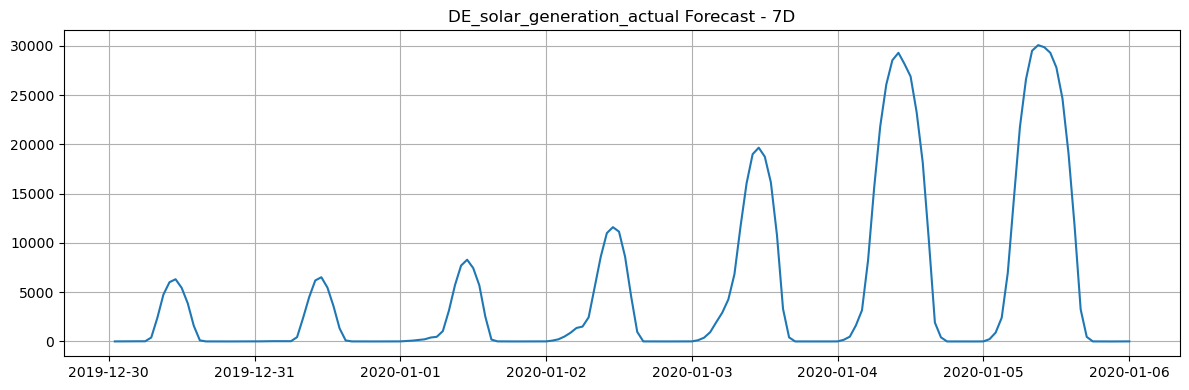

 - Horizon: 1m (720 hours)


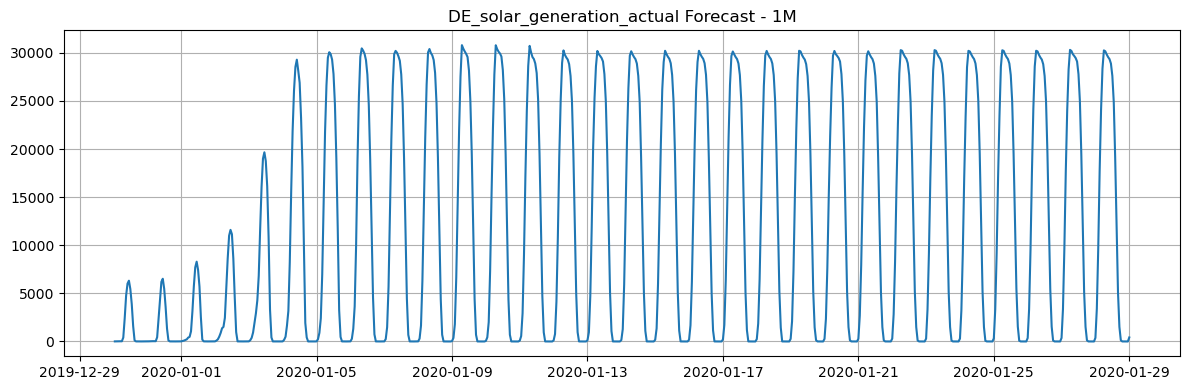

 - Horizon: 3m (2160 hours)


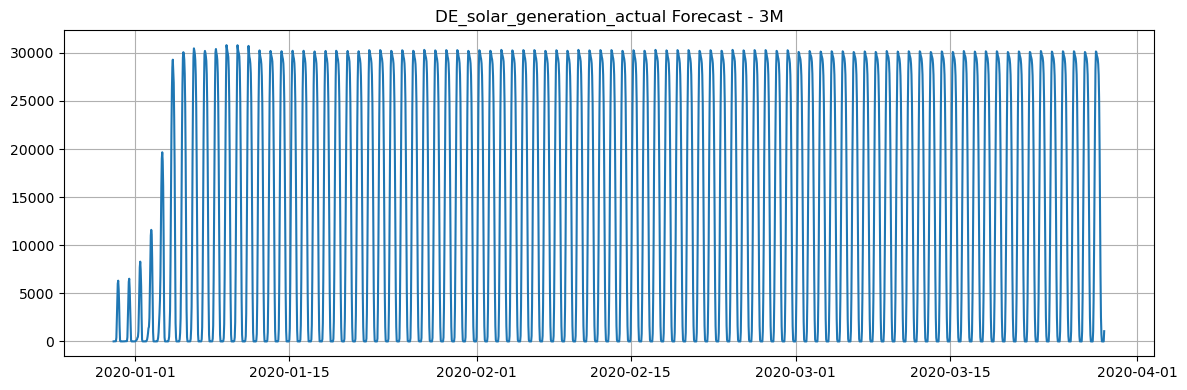

 - Horizon: 6m (4320 hours)


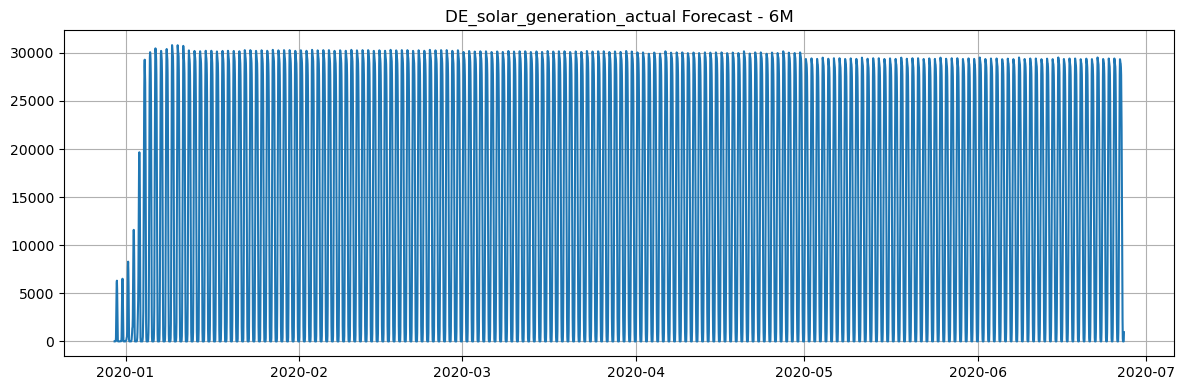

 - Horizon: 12m (8760 hours)


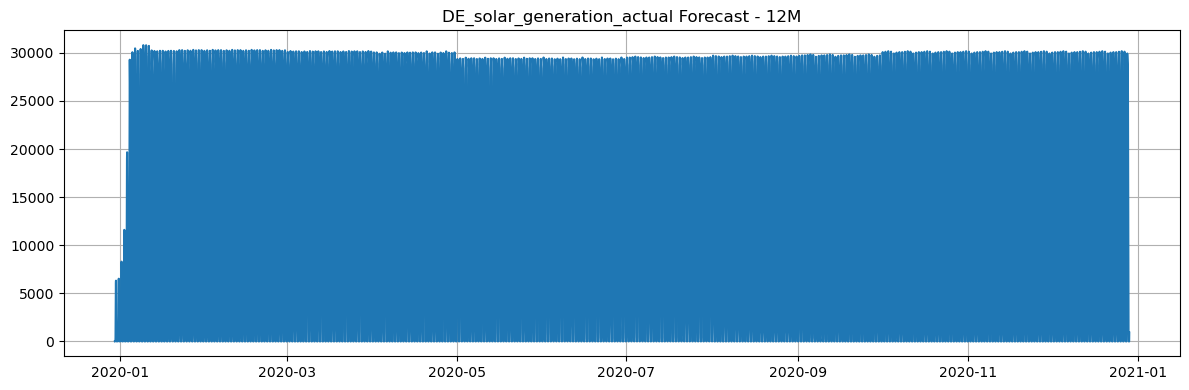


📡 Forecasting: DE_wind_generation_actual
 - Horizon: 1d (24 hours)


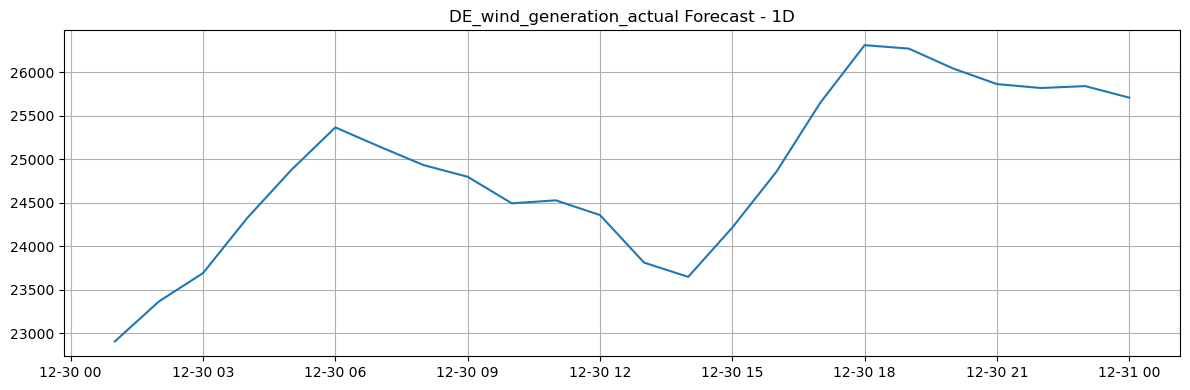

 - Horizon: 7d (168 hours)


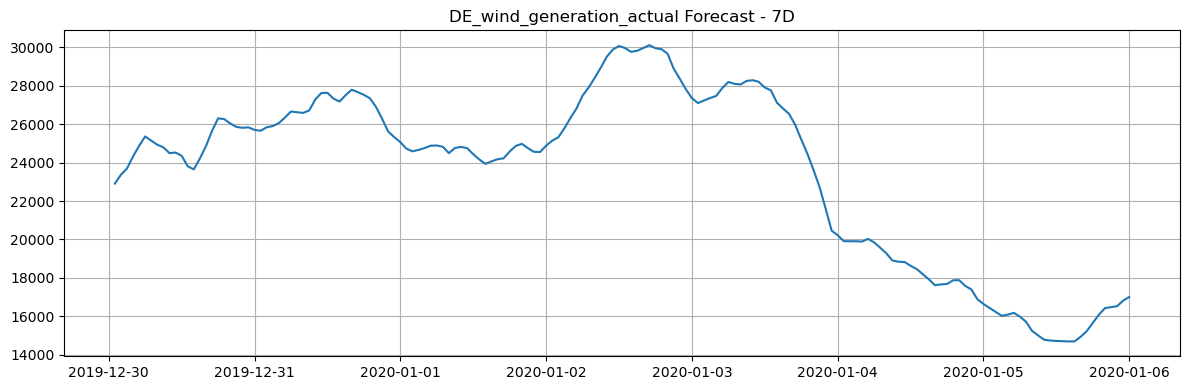

 - Horizon: 1m (720 hours)


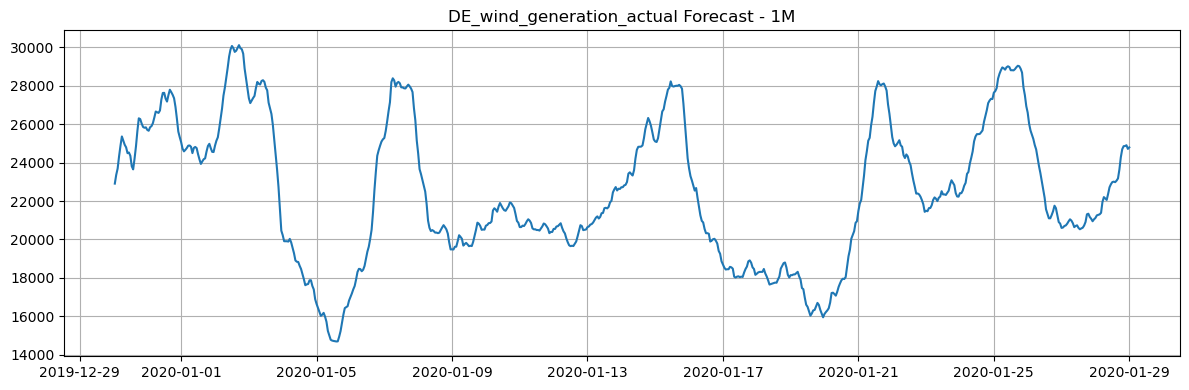

 - Horizon: 3m (2160 hours)


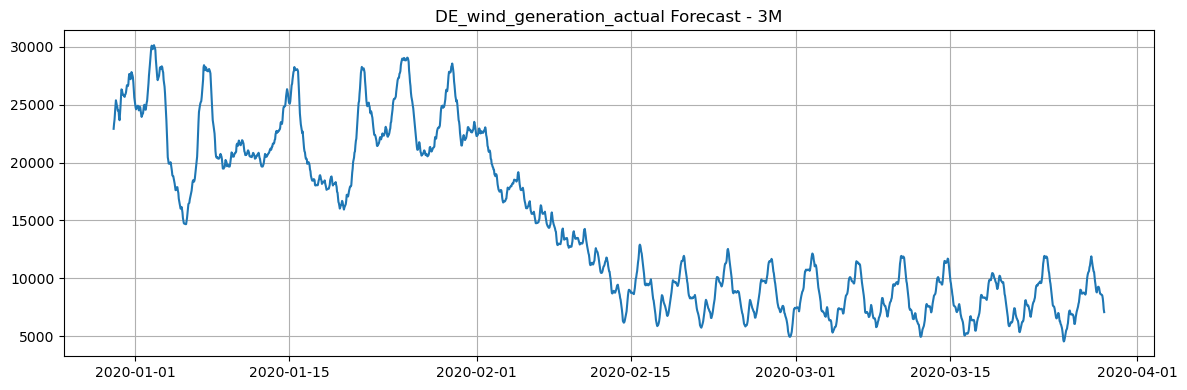

 - Horizon: 6m (4320 hours)


KeyboardInterrupt: 

In [3]:
for feature in features_to_forecast:
    print(f"\n📡 Forecasting: {feature}")

    # Train model on all available history
    df_feat = df[[feature]].copy()
    df_feat['lag_1h'] = df_feat[feature].shift(1)
    df_feat['lag_24h'] = df_feat[feature].shift(24)
    df_feat['lag_168h'] = df_feat[feature].shift(168)
    df_feat['roll_24h'] = df_feat[feature].rolling(24).mean()
    df_feat['roll_168h'] = df_feat[feature].rolling(168).mean()
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    df_feat = df_feat.dropna()

    X_train = df_feat.drop(columns=[feature])
    y_train = df_feat[feature]
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train, y_train)

    recursive_forecasts[feature] = {}

    for label, steps in horizons.items():
        print(f" - Horizon: {label} ({steps} hours)")
        history = base_history[[feature]].copy()
        forecasts = []

        for step in range(1, steps + 1):
            next_time = history.index[-1] + timedelta(hours=1)

            row = {
                'lag_1h': history[feature].iloc[-1],
                'lag_24h': history[feature].shift(23).iloc[-1] if len(history) >= 24 else np.nan,
                'lag_168h': history[feature].shift(167).iloc[-1] if len(history) >= 168 else np.nan,
                'roll_24h': history[feature].rolling(24).mean().iloc[-1] if len(history) >= 24 else np.nan,
                'roll_168h': history[feature].rolling(168).mean().iloc[-1] if len(history) >= 168 else np.nan,
                'hour': next_time.hour,
                'dayofweek': next_time.dayofweek,
                'month': next_time.month
            }

            row_df = pd.DataFrame([row], index=[next_time])
            if row_df.isnull().any(axis=1).iloc[0]:
                break

            pred = model.predict(row_df)[0]
            row_df[feature] = pred
            forecasts.append(row_df[[feature]])
            history = pd.concat([history, row_df[[feature]]])

        forecast_df = pd.concat(forecasts)
        recursive_forecasts[feature][label] = forecast_df

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(forecast_df.index, forecast_df[feature], label='Forecast')
        plt.title(f"{feature} Forecast - {label.upper()}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Trying to forecast the features 1 day, 1 week, 1 month.....12 months in order to use the data as input to predict the energy price of a certain day. But the results end up being periodical and do not represent reallife data </br>
Finished by Jad Akra on Friday 19th of April 2025